# Import libraries

In [1]:
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

from sklearn.datasets import load_digits
from sklearn import manifold

from scipy.spatial.distance import pdist, squareform

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

import folium

from scipy.stats import zscore

# %matplotlib notebook
import matplotlib.gridspec as gridspec

import re

def remove_top_right(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax


from sklearn.metrics import euclidean_distances

def plot_mds(similarities,ax,input_is_corr=False,xlim=None,ylim=None):
    # similarities is a dissimilarity matrix
        
    # plt.matshow(similarities)
    seed = np.random.RandomState(seed=3)
    mds = manifold.MDS(n_components=2, 
                       metric=True,
                       max_iter=3000, 
                       eps=1e-21, 
                       random_state=seed,
                       dissimilarity="precomputed", 
                       n_init=20,
                       n_jobs=1,
                       verbose=True)
    pos = mds.fit(similarities).embedding_
    pos = mds.fit_transform(similarities, init=pos)    
    ax.plot(pos[:,0],pos[:,1],'ok',markersize=15)
    for i, txt in enumerate(symm_df.columns):
        txt = re.sub(" ",r"\n", txt)
        ax.annotate(txt, (pos[i,0],  pos[i,1]+3),fontsize=15, ha='center', weight='bold')
    ax.set_ylabel('Dim2',fontsize=20)
    ax.set_xlabel('Dim1',fontsize=20)
    ax = remove_top_right(ax)
    ax.grid()
    plt.tight_layout()
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    if xlim is not None:
        S=xlim/2.0
        Tx = np.arange(-xlim, xlim+S,step=S)
        Ty = np.arange(-ylim, ylim+S,step=S)
        ax.set_xticks(Tx)
        ax.set_yticks(Ty)
        ax.set_ylim(-ylim,ylim)
        ax.set_xlim(-xlim,xlim)
    return ax

def correlation_panel(corr,ax,input_is_corr=False,TITLE='Correlation Matrix',annotate=True,cbar=True,MASK=None,fmt=".1"):
    # corr is a distance matrix
    # plot the heatmap
    TICKLABELS = corr.columns.str.replace(' ','\n')
    if annotate is True:
        sns.heatmap(corr, 
                xticklabels=TICKLABELS,
                yticklabels=TICKLABELS,
                cmap="RdBu_r",
                square=True,
                ax=ax,
                cbar_kws={"shrink": 0.5},
                annot=corr.values,
                cbar=cbar,mask=MASK,
                fmt=fmt,
                linewidth=1)
    else:
        sns.heatmap(corr, 
        xticklabels=TICKLABELS,
        yticklabels=TICKLABELS,
        cmap="RdBu_r",
        square=True,
        ax=ax,
        cbar_kws={"shrink": 0.5},
        cbar=cbar,
        mask=MASK,
        linewidth=1)
    ax.set_title(TITLE,fontsize=16)
    ax.set_yticklabels(TICKLABELS,fontsize=12,va='center')
    ax.set_xticklabels(TICKLABELS,fontsize=12,ha='center')
    plt.tight_layout()
    return ax
    #biraz deli bir renk oldu ama simdilik kalsin.
    
@memory.cache
def get_geo_distances(capitals):
    geolocator = Nominatim(user_agent="bla")
    Distance = np.zeros((len(capitals),len(capitals)))
    for i,c1 in enumerate(capitals):
        for j,c2 in enumerate(capitals):
            l1 = geolocator.geocode(c1)
            l2 = geolocator.geocode(c2)
            d = geodesic(l1.point, l2.point).km
            Distance[i,j] = d
    return Distance


# Import Data

In [3]:
symm_df = pd.read_excel("./data_paper_Greek.xlsx",index_col=0)
symm_df = symm_df.iloc[:17,[3,2,1,4,5,6]]
symm_df = symm_df.astype(float)

In [4]:
symm_df

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks,Hellenistic Greek
p1,0.8,14.04,0.00,0.27,0.8,9.8
p1m1,4.9,9.65,0.00,0.00,0.0,1.6
p1g1,0.0,0.88,0.00,0.00,0.8,0.0
c1m1,2.4,4.39,0.00,0.55,0.0,1.6
p211,0.0,2.63,3.60,1.10,2.4,0.0
p2mm,5.7,9.65,5.78,8.79,6.4,6.6
p2mg,0.8,5.26,0.44,0.82,0.8,1.6
p2gg,0.8,0.88,0.00,0.55,3.2,0.0
c2mm,1.6,3.51,12.89,8.52,11.2,6.6
p3,0.8,0.00,0.00,0.82,0.0,0.0


In [5]:
symm_df.sum()

Armenian             100.00
Eastern Roman        100.01
Middle East Arabs     99.99
Rum Seljuks           99.99
Great Seljuks        100.00
Hellenistic Greek     99.90
dtype: float64

In [6]:
dist_symm = pd.DataFrame(squareform(pdist(symm_df.T.values,'correlation'))
                            ,index=symm_df.columns, columns= symm_df.columns)
TOTAL_CULTURE = dist_symm.shape[0]
dist_symm

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks,Hellenistic Greek
Armenian,0.000000,0.151601,0.360039,0.280780,0.225098,0.043894
Eastern Roman,0.151601,0.000000,0.573249,0.520043,0.408869,0.072603
Middle East Arabs,0.360039,0.573249,0.000000,0.026510,0.116362,0.409957
Rum Seljuks,0.280780,0.520043,0.026510,0.000000,0.079154,0.357268
Great Seljuks,0.225098,0.408869,0.116362,0.079154,0.000000,0.276082
Hellenistic Greek,0.043894,0.072603,0.409957,0.357268,0.276082,0.000000


In [7]:
dist_symm_euc = pd.DataFrame(squareform(pdist(symm_df.T.values))
                            ,index=symm_df.columns, columns= symm_df.columns)
dist_symm_euc

,Armenian,Eastern Roman,Middle East Arabs,Rum Seljuks,Great Seljuks,Hellenistic Greek
Armenian,0.000000,28.763503,40.484055,35.974045,34.427315,18.156817
Eastern Roman,28.763503,0.000000,40.919348,35.912037,29.527294,29.967601
Middle East Arabs,40.484055,40.919348,0.000000,10.315270,20.302874,48.339577
Rum Seljuks,35.974045,35.912037,10.315270,0.000000,14.190980,45.628060
Great Seljuks,34.427315,29.527294,20.302874,14.190980,0.000000,43.261184
Hellenistic Greek,18.156817,29.967601,48.339577,45.628060,43.261184,0.000000


# Histogram of Symmetry Groups

<IPython.core.display.Javascript object>


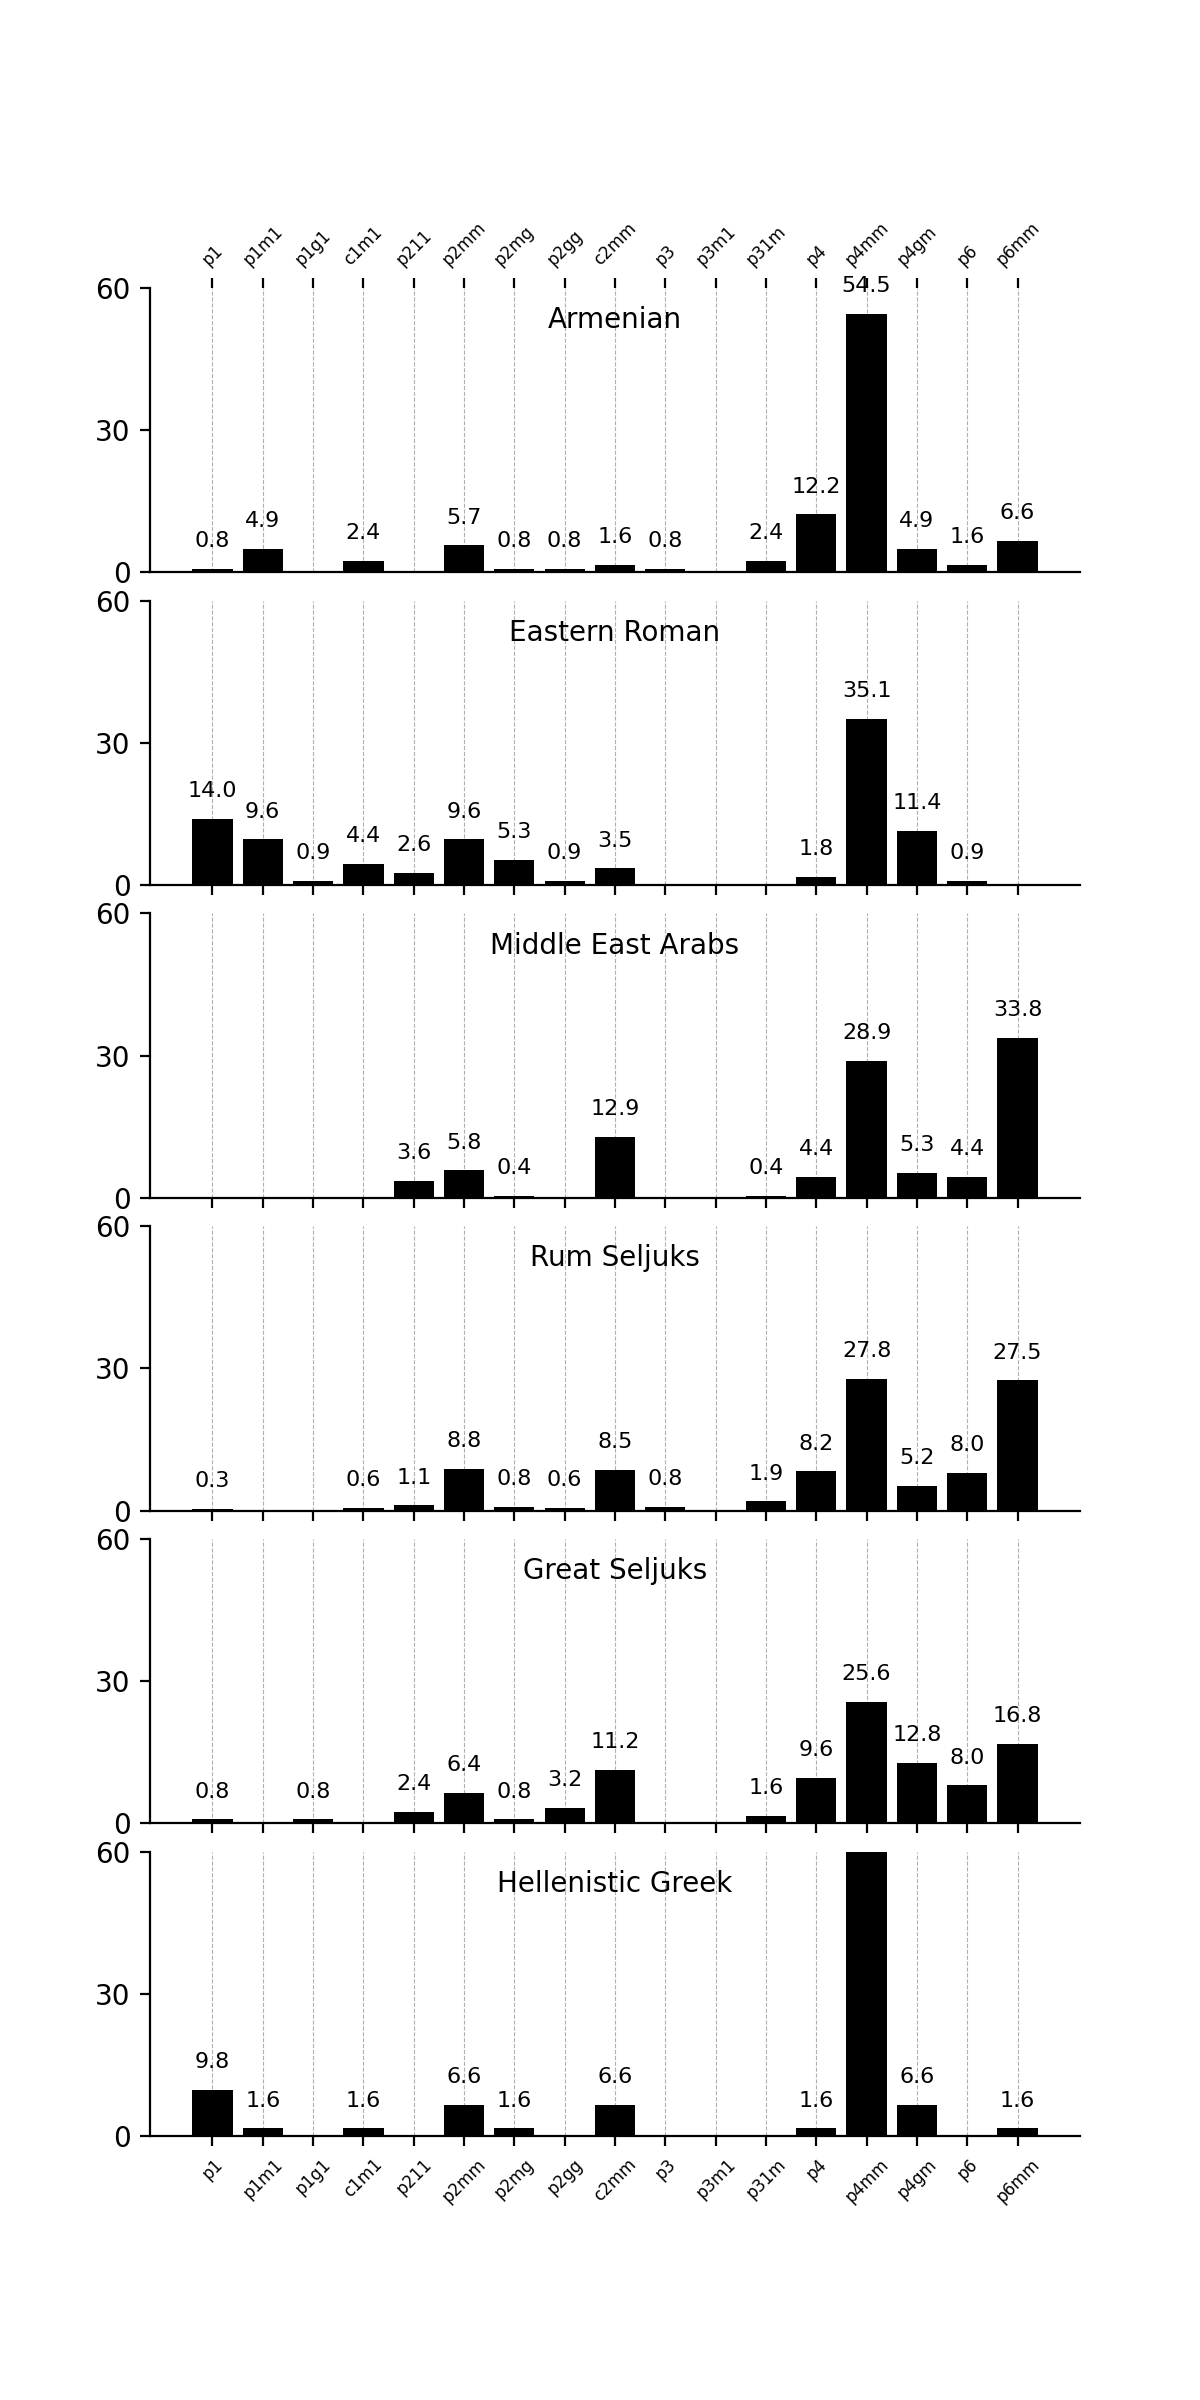

In [8]:
%matplotlib notebook
## FIGURE
fig = plt.figure(figsize=(TOTAL_CULTURE,12))
gs1 = gridspec.GridSpec(TOTAL_CULTURE,1)
gs1.update( hspace=0.1) # set the spacing between axes. 


cols = symm_df.columns.to_list() 
for i in np.arange(TOTAL_CULTURE):
    ax = plt.subplot(gs1[i])
    ax.bar(range(0,17),symm_df[cols[i]],color='k')
    ax = remove_top_right(ax)
    ax.set_xticks(np.arange(symm_df.shape[0]))
    if i == TOTAL_CULTURE-1:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
    elif i == 0:
        ax.set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=6,ha='center')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top') 
    else:
        ax.set_xticklabels('')
    for p in ax.patches:
        if np.ceil(p.get_height()) != 0:
            ax.annotate(np.round(p.get_height(),decimals=1),
                        (p.get_x()+p.get_width()/2., 
                         p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax.set_title(cols[i], y=0.8, loc = 'center',fontsize=10)
    ax.set_ylim([0,60])
    ax.set_yticks([0,30,60])
    ax.grid(axis='x', linestyle='--', linewidth=.4)
    ax.set_axisbelow(True)

    
plt.subplots_adjust(hspace=.5)
plt.savefig('/Users/onat/Documents/ornament_symmgroups/figure_histograms_paper_Greek.png',dpi=1000)

# Correlation between Symmetry Groups

<IPython.core.display.Javascript object>


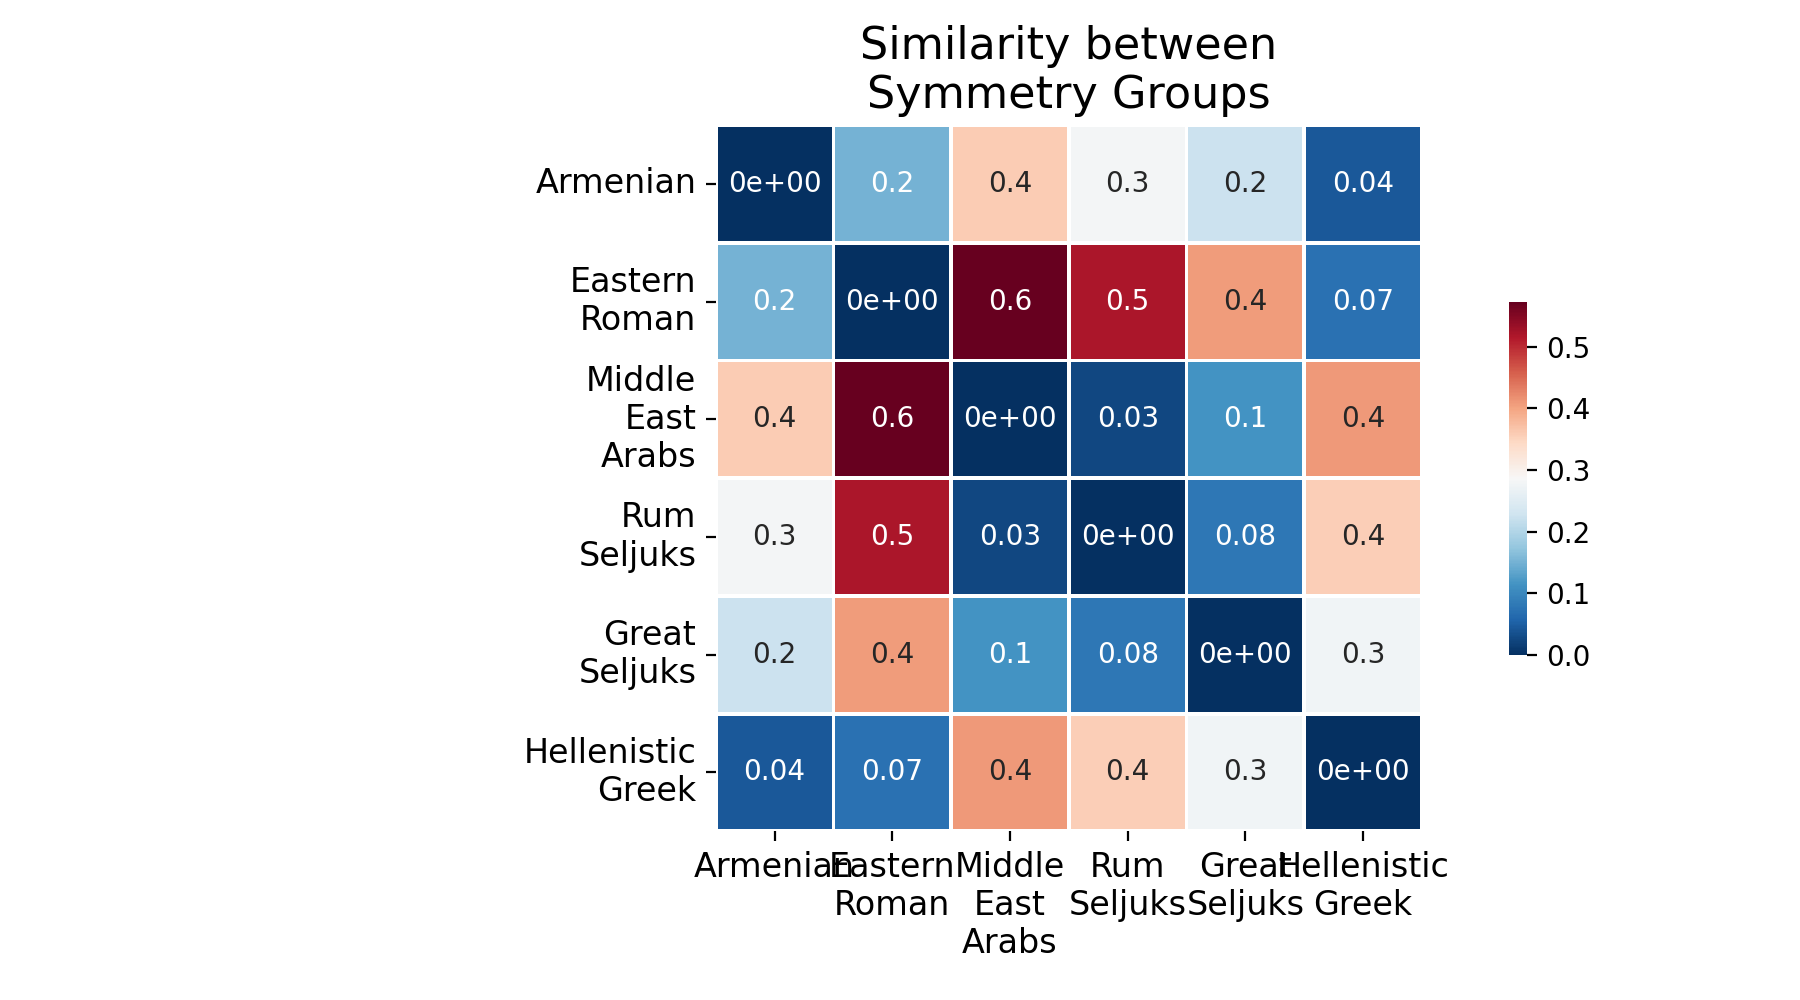

In [9]:
fig = plt.figure(figsize=(9,5))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm,ax=ax,TITLE='Similarity between\nSymmetry Groups')

plt.savefig('/Users/onat/Documents/ornament_symmgroups/figure_corrmat_paper_Greek.png',
                dpi=1000,
                )

# Euclidean Distance between Groups

<IPython.core.display.Javascript object>


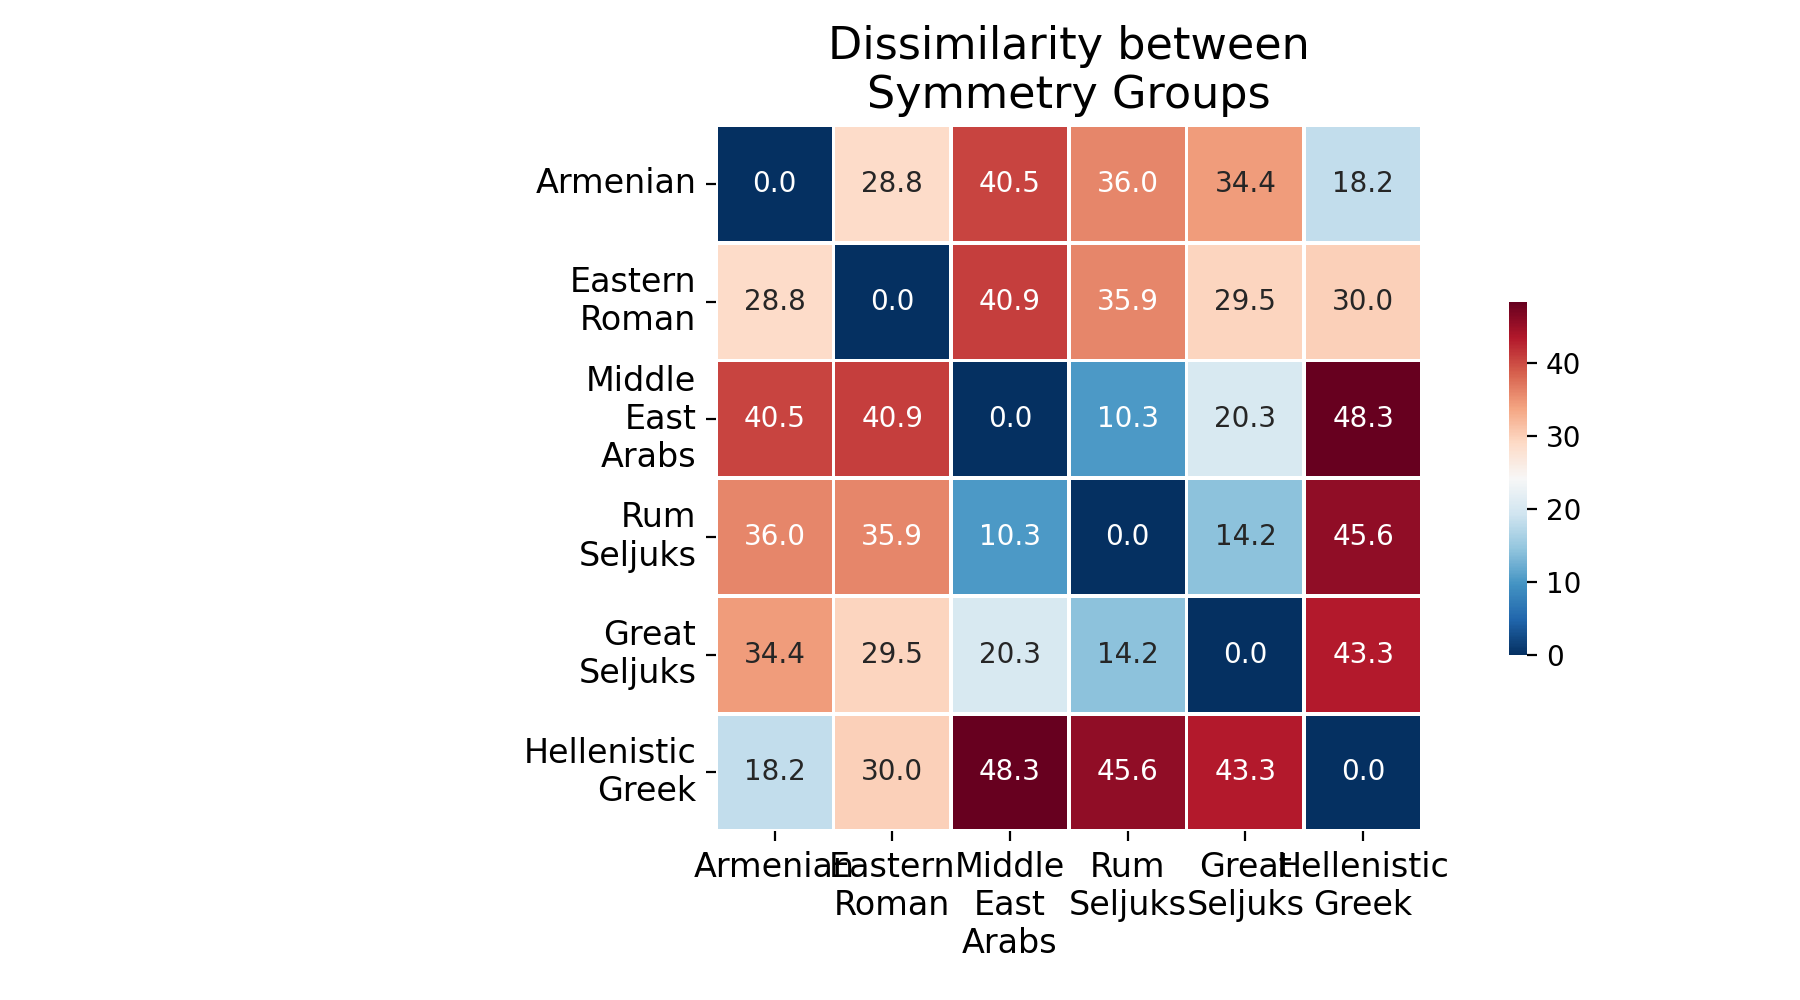

In [10]:
fig = plt.figure(figsize=(9,5))
ax  = fig.subplots(1,1)
# mask = np.triu(np.ones((5, 5), dtype=bool),0)==False
correlation_panel(dist_symm_euc,ax=ax,TITLE='Dissimilarity between\nSymmetry Groups',fmt='.1f')

plt.savefig('/Users/onat/Documents/ornament_symmgroups/figure_eucmat_paper_Greek.png',
                dpi=1000,
                )

# MDS on Symmetry Similarity

<IPython.core.display.Javascript object>


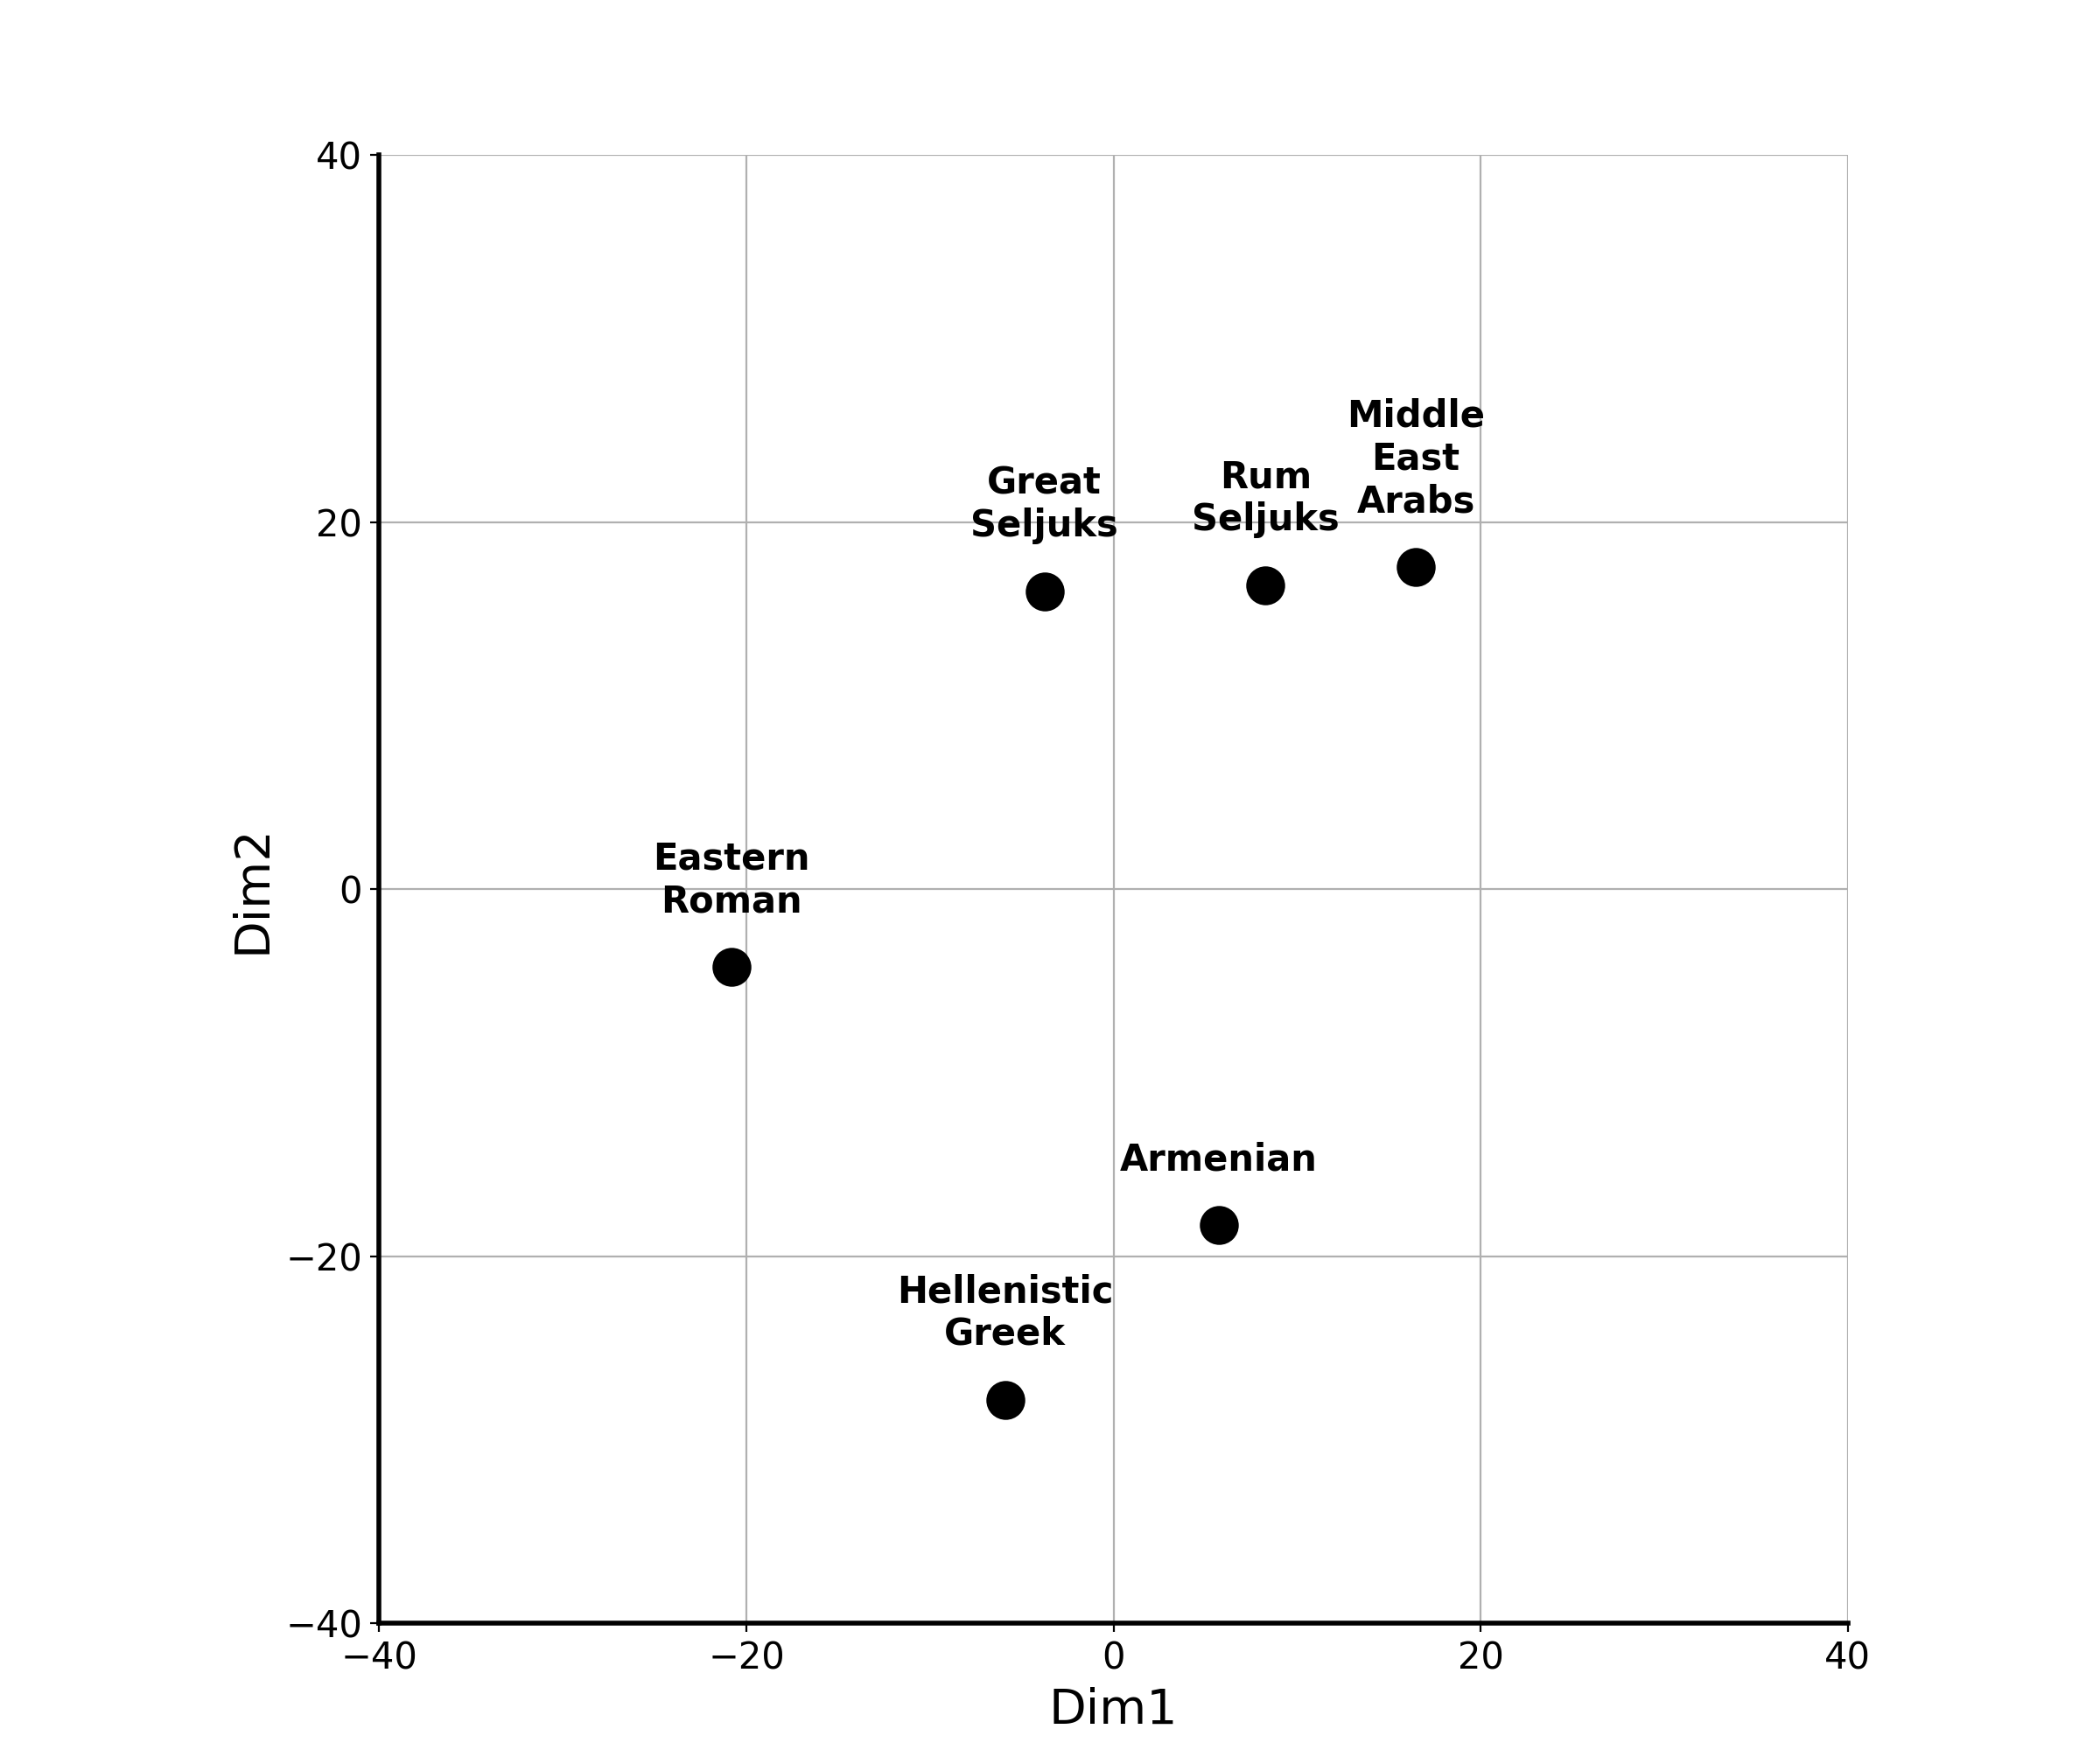

breaking at iteration 39 with stress 57.013567089195824
breaking at iteration 73 with stress 57.01345324749221
breaking at iteration 208 with stress 57.01344449841806
breaking at iteration 374 with stress 163.1121346674919
breaking at iteration 295 with stress 163.11213466749192
breaking at iteration 412 with stress 163.1121346674919
breaking at iteration 464 with stress 163.11213466749192
breaking at iteration 78 with stress 57.01345205720648
breaking at iteration 67 with stress 57.01345224685731
breaking at iteration 86 with stress 57.013453691408515
breaking at iteration 390 with stress 163.11213466749192
breaking at iteration 184 with stress 57.01344449841812
breaking at iteration 186 with stress 57.01344449841812
breaking at iteration 153 with stress 57.01344449841813
breaking at iteration 322 with stress 163.11213466749186
breaking at iteration 179 with stress 57.01344449841813
breaking at iteration 205 with stress 57.01344449841809
breaking at iteration 82 with stress 57.0134498

/Users/onat/Documents/ornament_symmgroups/.env/lib/python3.7/site-packages/sklearn/manifold/_mds.py:241: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 20
  % n_init)


In [11]:
fig = plt.figure(figsize=(12,10))
ax  = fig.subplots(1,1)
ax  = plot_mds(dist_symm_euc ,ax,xlim=40,ylim=40)
for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2)
plt.savefig('/Users/onat/Documents/ornament_symmgroups/figure_mds_paper_Greek.png',dpi=1000)